# Exploratory Data Analysis

In [ ]:
from google.colab import drive
drive.mount('./gdrive')

Mounted at ./gdrive


In [ ]:
%%capture
import sys

!{sys.executable} -m pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension
!pip install phik==0.10.0
!pip install association-metrics
!!pip install catboost

In [ ]:
%matplotlib inline 
import os
import numpy as np                 # linear algebra
import pandas as pd                # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import sklearn as sk               # Useful in data analysis
from datetime import date
import matplotlib.pyplot as plt

import phik
import association_metrics
import pandas_profiling
from pandas_profiling.utils.cache import cache_file

In [ ]:
data_dir = "./gdrive/MyDrive/DataStorm-2.0/datasets"

train_df = pd.read_csv(os.path.join(data_dir, "Hotel-A-train.csv"))
valid_df = pd.read_csv(os.path.join(data_dir, "Hotel-A-validation.csv"))
test_df = pd.read_csv(os.path.join(data_dir, "Hotel-A-test.csv"))

### Data Insights

In [ ]:
print(f'train dataset size :: {train_df.shape}')
print(f'valid dataset size :: {valid_df.shape}')
print(f'test dataset size  :: {test_df.shape}')         # test dataset do not have the label (Reservation_Status)

train dataset size :: (27499, 24)
valid dataset size :: (2749, 24)
test dataset size  :: (4318, 23)


In [ ]:
attributes = list(train_df.columns)
print(attributes)

['Reservation-id', 'Gender', 'Age', 'Ethnicity', 'Educational_Level', 'Income', 'Country_region', 'Hotel_Type', 'Expected_checkin', 'Expected_checkout', 'Booking_date', 'Adults', 'Children', 'Babies', 'Meal_Type', 'Visted_Previously', 'Previous_Cancellations', 'Deposit_type', 'Booking_channel', 'Required_Car_Parking', 'Reservation_Status', 'Use_Promotion', 'Discount_Rate', 'Room_Rate']


In [ ]:
train_report = train_df.profile_report(
    sort="None", html={"style": {"full_width": True}}, progress_bar=False )
#train_report

In [ ]:
valid_report = valid_df.profile_report(
    sort="None", html={"style": {"full_width": True}}, progress_bar=False
)
#valid_report 

In [ ]:
test_report = test_df.profile_report(
    sort="None", html={"style": {"full_width": True}}, progress_bar=False
)
#test_report 

### Understanding Target variable

In [1]:
train_df.Reservation_Status.unique()

NameError: ignored

In [2]:
train_df.Reservation_Status.value_counts()

NameError: ignored

In [ ]:
valid_df.Reservation_Status.value_counts()

## Data Pre-processing

### Checking for nulls and NaNs

In [ ]:
# Train Dataframe
print(f'Train Series nulls :: {train_df.isnull().values.sum()}')
print(f'Train Series NaNs :: {train_df.isna().values.sum()}')

Train Series nulls :: 0
Train Series NaNs :: 0


In [ ]:
# Validation Dataframe
print(f'Validation Series nulls :: {valid_df.isnull().values.sum()}')
print(f'Validation Series NaNs :: {valid_df.isna().values.sum()}')

Validation Series nulls :: 0
Validation Series NaNs :: 0


In [ ]:
# Test Dataframe
print(f'Test Series nulls :: {test_df.isnull().values.sum()}')
print(f'Test Series NaNs :: {test_df.isna().values.sum()}')

Test Series nulls :: 0
Test Series NaNs :: 0


In [ ]:
# dataframes for analysis
prep_train = train_df[['Reservation-id']].copy()
prep_valid = valid_df[['Reservation-id']].copy()
prep_test  = test_df[['Reservation-id']].copy()

### Converting the Date variables

In [ ]:
#Convert Dates to continuous variables
def date_to_num(d):
    d = d.split('/')
    d = list(map(int, d))
    month, day, year = d
    ref_date = date(2015,1,1)
    cur_date = date(year,month,day)
    delta = cur_date - ref_date
    return int(delta.days)

def date_to_month(d):
    d = d.split('/')
    d = list(map(int, d))
    month, day, year = d
    return str(month)

def date_to_year(d):
  d = d.split('/')
  d = list(map(int, d))
  month, day, year = d
  return year

In [ ]:
in_dfs = [train_df, valid_df, test_df]
out_dfs = [prep_train, prep_valid, prep_test]

for i in range(len(in_dfs)):
  out_dfs[i]['in_day']      =  in_dfs[i]['Expected_checkin'].map(lambda d: date_to_num(d))
  out_dfs[i]['out_day']     =  in_dfs[i]['Expected_checkout'].map(lambda d: date_to_num(d))
  out_dfs[i]['in_month']    =  in_dfs[i]['Expected_checkin'].map(lambda d: date_to_month(d))
  out_dfs[i]['out_month']   =  in_dfs[i]['Expected_checkout'].map(lambda d: date_to_month(d))
  out_dfs[i]['in_year']     =  in_dfs[i]['Expected_checkin'].map(lambda d: date_to_year(d))
  out_dfs[i]['duration']    =  out_dfs[i]['out_day'] - out_dfs[i]['in_day']
  out_dfs[i]['book_day']    =  in_dfs[i]['Booking_date'].map(lambda d: date_to_num(d))
  out_dfs[i]['book_month']  =  in_dfs[i]['Booking_date'].map(lambda d: date_to_month(d))
  out_dfs[i]['book2check']  =  out_dfs[i]['in_day']  - out_dfs[i]['book_day']

  out_dfs[i]['book2check'][out_dfs[i]['book2check'] < 0] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernel

In [ ]:
prep_train.head(5)

,Reservation-id,in_day,out_day,in_month,out_month,in_year,duration,book_day,book_month,book2check
0,39428300,181,182,7,7,2015,1,140,5,41
1,77491756,181,182,7,7,2015,1,145,5,36
2,73747291,182,186,7,7,2015,4,179,6,3
3,67301739,182,183,7,7,2015,1,170,6,12
4,77222321,183,184,7,7,2015,1,170,6,13


### Converting the un-ordered categorical variables

In [ ]:
def check_sim(in_dfs, col):
    # checks for different features in different dataframes
    train_ = np.sort(in_dfs[0][col].unique())
    valid_ = np.sort(in_dfs[1][col].unique())
    test_  = np.sort(in_dfs[2][col].unique())
    if (train_ == valid_).all() and (train_ == test_).all():
        return True
    else:
        return False

In [ ]:
from sklearn.preprocessing import LabelEncoder

def unord_cat(col, in_dfs, out_dfs):
    # converts the categorical values to numerical labels
    enc = LabelEncoder()
    
    if check_sim(in_dfs, col):
        enc.fit(in_dfs[0][col]) # fits only on the train data features. 
    else:
        # if the three dataframes are having different features, should get a combined feature list
        features = []
        for i in range(len(in_dfs)):
          features += in_dfs[i][col].tolist()
        features = list(set(features))
        enc.fit(features)
    
    for n in range(len(out_dfs)):
        out_dfs[n][col] = enc.transform(in_dfs[n][col])
        
    return dict(zip(enc.classes_, enc.transform(enc.classes_)))

In [ ]:
orderless_categoricals = ['Gender', 'Educational_Level', 'Ethnicity','Country_region', 
                          'Hotel_Type', 'Meal_Type', 'Deposit_type', 'Booking_channel']
map_dicts = {}
for cat in orderless_categoricals:
    map_dicts[cat] = unord_cat(cat, in_dfs, out_dfs)

### Converting the ordered categorical variables

In [ ]:
ordered_categoricals = ['Education_Level', 'Income']

In [ ]:
def conv_Edu(in_df, out_df, col = 'Educational_Level'):
  map_ = {'Grad':3, 'Mid-School':0, 'College':2, 'High-School':1}
  out_df[col] = in_df[col].map(map_)
  return map_

In [ ]:
for indf, outdf in zip(in_dfs, out_dfs):
  map_dicts['Educational_Level'] = conv_Edu(indf, outdf)

In [ ]:
def conv_income(in_df, out_df, col = 'Income'):
  map_ = {'<25K':0, '50K -- 100K':2, '>100K':3, '25K --50K':4}
  out_df[col] = in_df[col].map(map_)
  return map_

In [ ]:
for indf, outdf in zip(in_dfs, out_dfs):
  map_dicts['Income'] = conv_income(indf, outdf)

### Standarizing the continuous variables

In [ ]:
def standarize(out_dfs, col):
  stand = sk.preprocessing.MinMaxScaler()
  stand.fit(out_dfs[0][col].to_numpy().reshape(-1, 1))

  for i in range(len(out_dfs)):
    out_dfs[i][col] = stand.transform(out_dfs[i][col].to_numpy().reshape(-1, 1))
  return

In [ ]:
conts_data = ['Discount_Rate', 'Room_Rate', 'duration', 'book2check', 'in_day', 'out_day', 'book_day', "Spend"]

for cat_ in conts_data[:2]:
  for indf, outdf in zip(in_dfs, out_dfs):
    outdf[cat_] = indf[cat_]

for indf, outdf in zip(in_dfs, out_dfs):
  outdf["Spend"] = outdf['Room_Rate']*(1-outdf['Discount_Rate']/100)*indf["Adults"]

for cat_ in conts_data:
  standarize(out_dfs, cat_)

### Converting Boolean type variables

In [ ]:
def conv_bool(in_df, out_df, col):
    map_ = {'yes':1, 'no':0}
    out_df[col] = in_df[col].str.lower()
    out_df[col] = out_df[col].map(map_)
    return

In [ ]:
boolean_data = ['Visted_Previously','Previous_Cancellations','Required_Car_Parking','Use_Promotion']

for bol_ in boolean_data:
  for indf, outdf in zip(in_dfs, out_dfs):
    conv_bool(indf, outdf, bol_)

### Converting Month Data

In [ ]:
month_data = ['in_month', 'out_month', 'book_month']

for cat in month_data:
  for outdf in out_dfs:
    outdf[cat] = outdf[cat].astype('int64')

### Age, Number of Visitors

In [ ]:
cat_cont = ['Age', 'Adults', 'Children', 'Babies']

df_new = train_df[cat_cont].copy()
df_new['Reservation_Status'] = train_df['Reservation_Status']

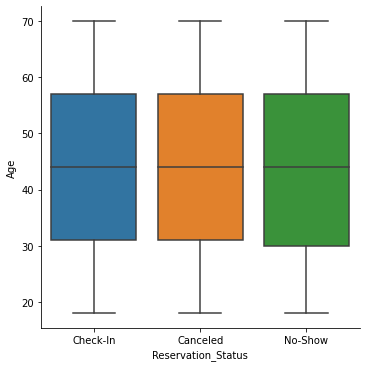

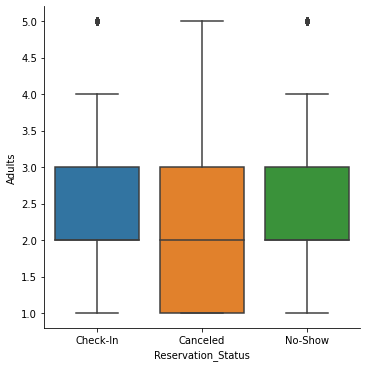

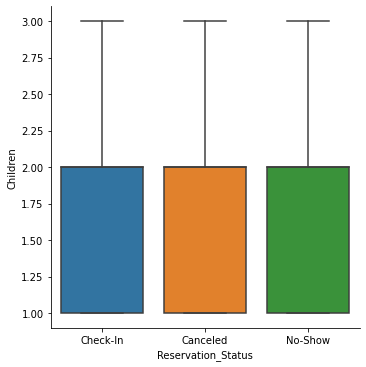

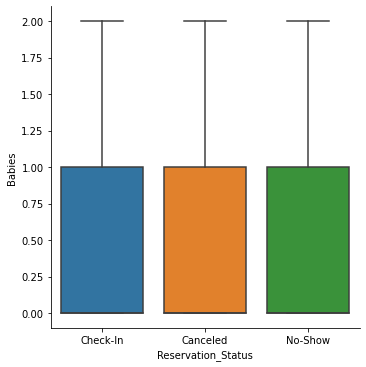

In [ ]:
sns.catplot(x="Reservation_Status", y="Age", data=df_new, kind="box")
sns.catplot(x="Reservation_Status", y="Adults", data=df_new, kind="box")
sns.catplot(x="Reservation_Status", y="Children", data=df_new, kind="box")
sns.catplot(x="Reservation_Status", y="Babies", data=df_new, kind="box")

In [ ]:
df_new.phik_matrix()

interval columns not set, guessing: ['Age', 'Adults', 'Children', 'Babies']


,Age,Adults,Children,Babies,Reservation_Status
Age,1.000000,0.021379,0.000000,0.00000,0.000000
Adults,0.021379,1.000000,0.000000,0.00000,0.013212
Children,0.000000,0.000000,1.000000,0.00000,0.028655
Babies,0.000000,0.000000,0.000000,1.00000,0.032490
Reservation_Status,0.000000,0.013212,0.028655,0.03249,1.000000


In [ ]:
# breaking the Age to categories to see any correlation exists
def age_to_cat(age):
  if age < 25:
    return 1
  elif age < 35:
    return 2
  else:
    return 3

interval columns not set, guessing: ['Age', 'AgeCat']
                         Age    AgeCat  Reservation_Status
Age                 1.000000  0.937968            0.000000
AgeCat              0.937968  1.000000            0.016466
Reservation_Status  0.000000  0.016466            1.000000


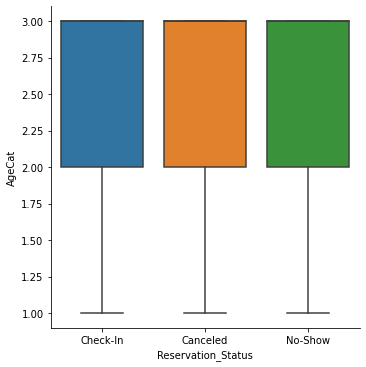

In [ ]:
df_age = df_new[['Age']].copy()
df_age['AgeCat'] = df_age['Age'].map(lambda a: age_to_cat(a))
df_age['Reservation_Status'] = df_new['Reservation_Status']

print(df_age.phik_matrix())
sns.catplot(x="Reservation_Status", y="AgeCat", data=df_age, kind="box")

In [ ]:
# Total visitors as a feature
df_visitor = df_new[['Adults', 'Children', 'Babies']].copy()
df_visitor['All3'] = df_visitor['Adults'] + df_visitor['Children'] + df_visitor['Babies']
df_visitor['AC'] = df_visitor['Adults'] + df_visitor['Children']
df_visitor['AB'] = df_visitor['Adults'] + df_visitor['Babies']
df_visitor['BC'] = df_visitor['Children'] + df_visitor['Babies']
df_visitor['Reservation_Status'] = df_new['Reservation_Status']

print(df_visitor.phik_matrix())

interval columns not set, guessing: ['Adults', 'Children', 'Babies', 'All3', 'AC', 'AB', 'BC']
                      Adults  Children  ...        BC  Reservation_Status
Adults              1.000000  0.000000  ...  0.005927            0.013212
Children            0.000000  1.000000  ...  0.707616            0.028655
Babies              0.000000  0.000000  ...  0.574388            0.032490
All3                0.707496  0.686365  ...  0.630743            0.000000
AC                  0.732004  0.584624  ...  0.377457            0.009393
AB                  0.817933  0.008006  ...  0.252973            0.019822
BC                  0.005927  0.707616  ...  1.000000            0.012312
Reservation_Status  0.013212  0.028655  ...  0.012312            1.000000

[8 rows x 8 columns]


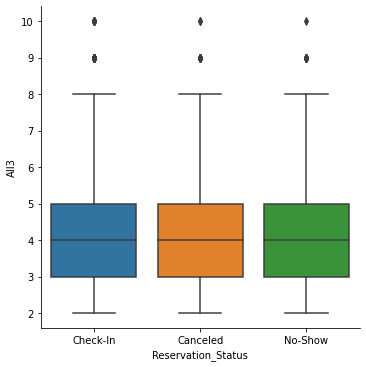

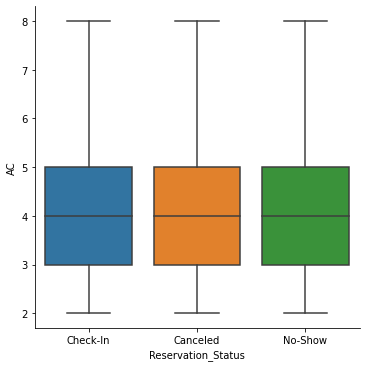

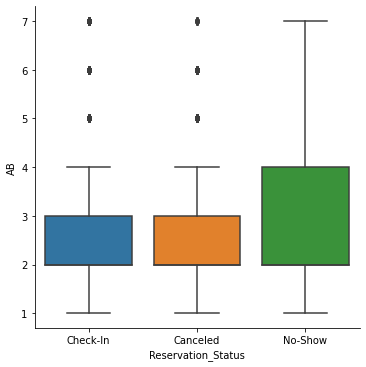

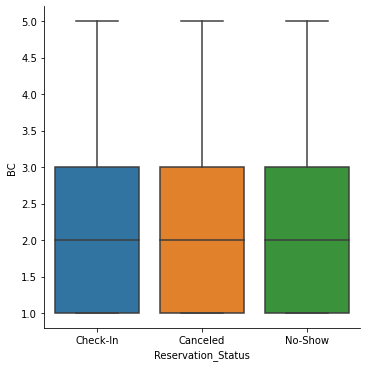

In [ ]:
sns.catplot(x="Reservation_Status", y='All3', data=df_visitor, kind="box")
sns.catplot(x="Reservation_Status", y='AC', data=df_visitor, kind="box")
sns.catplot(x="Reservation_Status", y='AB', data=df_visitor, kind="box")
sns.catplot(x="Reservation_Status", y='BC', data=df_visitor, kind="box")

In [ ]:
df1 = df_visitor.drop(df_visitor[(df_visitor.All3 > 8)].sample(frac=.25).index)
df2 = df_visitor.drop(df_visitor[(df_visitor.AB > 4) & (df_visitor.Reservation_Status == 1)].sample(frac=.25).index)
df2 = df2.drop(df2[(df2.AB > 4) & (df2.Reservation_Status == 2)].sample(frac=.25).index)

interval columns not set, guessing: ['Adults', 'Children', 'Babies', 'All3', 'AC', 'AB', 'BC']
                      Adults  Children  ...        BC  Reservation_Status
Adults              1.000000  0.000000  ...  0.027483            0.013172
Children            0.000000  1.000000  ...  0.707238            0.029081
Babies              0.000000  0.000000  ...  0.572178            0.032165
All3                0.706314  0.683981  ...  0.622626            0.009014
AC                  0.731234  0.582826  ...  0.375528            0.009276
AB                  0.817759  0.023210  ...  0.244798            0.020910
BC                  0.027483  0.707238  ...  1.000000            0.012145
Reservation_Status  0.013172  0.029081  ...  0.012145            1.000000

[8 rows x 8 columns]


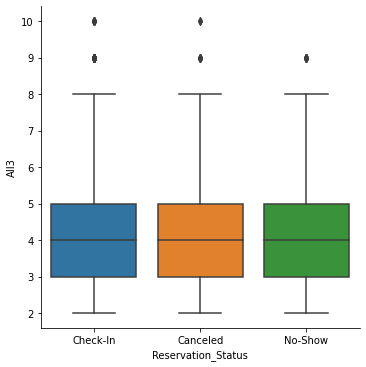

In [ ]:
print(df1.phik_matrix())
sns.catplot(x="Reservation_Status", y='All3', data=df1, kind="box")

interval columns not set, guessing: ['Adults', 'Children', 'Babies', 'All3', 'AC', 'AB', 'BC']
                      Adults  Children  ...        BC  Reservation_Status
Adults              1.000000  0.000000  ...  0.005927            0.013212
Children            0.000000  1.000000  ...  0.707616            0.028655
Babies              0.000000  0.000000  ...  0.574388            0.032490
All3                0.707496  0.686365  ...  0.630743            0.000000
AC                  0.732004  0.584624  ...  0.377457            0.009393
AB                  0.817933  0.008006  ...  0.252973            0.019822
BC                  0.005927  0.707616  ...  1.000000            0.012312
Reservation_Status  0.013212  0.028655  ...  0.012312            1.000000

[8 rows x 8 columns]


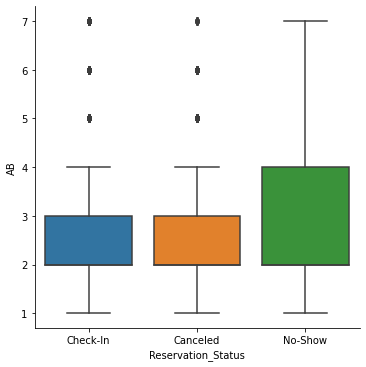

In [ ]:
print(df2.phik_matrix())
sns.catplot(x="Reservation_Status", y='AB', data=df2, kind="box")

**Observation: The second feature engineering works well.**

In [ ]:
feat = ["Age_Cat", "Adults", "Children", "Babies", "Total_visitor"]

for indf, outdf in zip(in_dfs, out_dfs):
  outdf["Age_Cat"] = indf["Age"].map(lambda a: age_to_cat(a))
  outdf["Adults"] = indf["Adults"]
  outdf["Children"] = indf["Children"]
  outdf["Babies"] = indf["Babies"]
  outdf["Total_visitor"] = outdf["Adults"] + outdf["Children"] + outdf["Babies"]
  outdf["Total_AB"] = outdf["Adults"] + outdf["Babies"]
  outdf["Total_AC"] = outdf["Adults"] + outdf["Children"]

### Adding Label Column

In [ ]:
train_df.Reservation_Status.unique()

array(['Check-In', 'Canceled', 'No-Show'], dtype=object)

In [ ]:
map_dicts['Reservation_Status'] = {'Check-In':1, 'Canceled':2, 'No-Show':3}

prep_train['Reservation_Status'] = train_df['Reservation_Status'].map(map_dicts['Reservation_Status'])
prep_valid['Reservation_Status'] = valid_df['Reservation_Status'].map(map_dicts['Reservation_Status'])

20294    1
9894     1
9895     1
12999    1
19869    1
9896     1
19870    1
11133    1
9892     1
19872    1
Name: in_month, dtype: int64


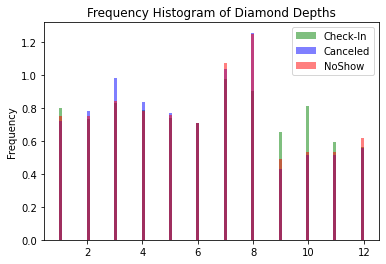

In [ ]:
xx = prep_train.sort_values('in_month')
x1 = xx.loc[xx.Reservation_Status==1, 'in_month']
x2 = xx.loc[xx.Reservation_Status==2, 'in_month']
x3 = xx.loc[xx.Reservation_Status==3, 'in_month']
print(x1[:10])
kwargs = dict(alpha=0.5, bins=100)

plt.hist(x1, **kwargs, color='g', label='Check-In', density=True)
plt.hist(x2, **kwargs, color='b', label='Canceled', density=True)
plt.hist(x3, **kwargs, color='r', label='NoShow',  density=True)
plt.gca().set(title='Frequency Histogram of Diamond Depths', ylabel='Frequency')
#plt.xlim(50,75)
plt.legend();

In [ ]:
# Removing Outliers identified
prep_train = prep_train.drop(prep_train[((prep_train.Total_AB > 5) & (prep_train.Reservation_Status == 1))|((prep_train.Total_AB > 5) & (prep_train.Reservation_Status == 2))].sample(frac=.25).index)

In [ ]:
print(f'Training dataframe shape :: {prep_train.shape}')

Training dataframe shape :: (27311, 34)


In [ ]:
prep_train_report = prep_train.profile_report(
                    sort="None", html={"style": {"full_width": True}}, progress_bar=False )

In [ ]:
#prep_train_report

In [ ]:
conf_matrix = prep_train[prep_train.columns[1:]].corr()['Reservation_Status'][:]
conf_matrix

in_day                   -0.028830
out_day                  -0.028846
in_month                 -0.015703
out_month                -0.013005
in_year                  -0.017699
duration                 -0.003354
book_day                 -0.025370
book_month               -0.055411
book2check               -0.005794
Gender                   -0.000364
Educational_Level        -0.002431
Ethnicity                -0.004930
Country_region           -0.000298
Hotel_Type                0.009939
Meal_Type                 0.122712
Deposit_type             -0.017563
Booking_channel           0.001759
Income                    0.000620
Discount_Rate            -0.002559
Room_Rate                 0.003050
Spend                     0.008616
Visted_Previously        -0.007189
Previous_Cancellations   -0.005252
Required_Car_Parking      0.004439
Use_Promotion             0.003896
Age_Cat                   0.005176
Adults                    0.007247
Children                  0.007724
Babies              

In [ ]:
#features_selected = 'in_day, duration, book2check, Gender, Hotel_Type, Meal_Type, Spend, Adults, Total_visitor, Reservation-id'
#features_selected = features_selected.split(', ')

In [ ]:
# Removing the columns with high correlation between the data points
abs_cm = prep_train[prep_train.columns[:-1]].corr().abs()
upper = abs_cm.where(np.triu(np.ones(abs_cm.shape), k=1).astype(np.bool))
print (upper)
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
print (to_drop)

                        Reservation-id    in_day  ...  Total_AB  Total_AC
Reservation-id                     NaN  0.003673  ...  0.009101  0.014618
in_day                             NaN       NaN  ...  0.000754  0.000204
out_day                            NaN       NaN  ...  0.000752  0.000238
in_month                           NaN       NaN  ...  0.008798  0.007697
out_month                          NaN       NaN  ...  0.008006  0.006952
in_year                            NaN       NaN  ...  0.004374  0.003453
duration                           NaN       NaN  ...  0.000381  0.006674
book_day                           NaN       NaN  ...  0.002671  0.003602
book_month                         NaN       NaN  ...  0.010666  0.003971
book2check                         NaN       NaN  ...  0.005197  0.009037
Gender                             NaN       NaN  ...  0.003264  0.001708
Educational_Level                  NaN       NaN  ...  0.009505  0.009338
Ethnicity                          NaN

In [ ]:
prep_train.drop(to_drop, axis=1, inplace=True)
prep_valid.drop(to_drop, axis=1, inplace=True)
prep_test.drop(to_drop, axis=1, inplace=True)

In [ ]:
updated_cm = prep_train.corr().abs()
label_row = updated_cm.iloc[-1,:-1]
label_row

Reservation-id            0.005121
in_day                    0.028830
in_month                  0.015703
duration                  0.003354
book_month                0.055411
book2check                0.005794
Gender                    0.000364
Educational_Level         0.002431
Ethnicity                 0.004930
Country_region            0.000298
Hotel_Type                0.009939
Meal_Type                 0.122712
Deposit_type              0.017563
Booking_channel           0.001759
Income                    0.000620
Discount_Rate             0.002559
Room_Rate                 0.003050
Spend                     0.008616
Visted_Previously         0.007189
Previous_Cancellations    0.005252
Required_Car_Parking      0.004439
Use_Promotion             0.003896
Age_Cat                   0.005176
Children                  0.007724
Babies                    0.007823
Name: Reservation_Status, dtype: float64

In [ ]:
features = prep_train.columns[:-1].tolist()
label = prep_train.columns[-1]

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

feat_selector = SelectKBest(chi2, k='all').fit(prep_train.iloc[:,:-1], prep_train.iloc[:,-1])

x_train = feat_selector.transform(prep_train.iloc[:,:-1])
x_valid = feat_selector.transform(prep_valid.iloc[:,:-1])
x_test = feat_selector.transform(prep_test)

# Model Fitting

### XGBoost Model

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

xgbModel = xgb.XGBClassifier()

eval_set = [(x_train, y_train), (x_valid, y_valid)]
eval_metric = ["merror"]

xgbModel.fit(x_train, y_train, eval_metric=eval_metric, eval_set=eval_set)

[0]	validation_0-merror:0.22815	validation_1-merror:0.414332
[1]	validation_0-merror:0.22815	validation_1-merror:0.414332
[2]	validation_0-merror:0.22815	validation_1-merror:0.414332
[3]	validation_0-merror:0.22815	validation_1-merror:0.414332
[4]	validation_0-merror:0.22815	validation_1-merror:0.414332
[5]	validation_0-merror:0.22815	validation_1-merror:0.414332
[6]	validation_0-merror:0.22815	validation_1-merror:0.414332
[7]	validation_0-merror:0.22815	validation_1-merror:0.414332
[8]	validation_0-merror:0.22815	validation_1-merror:0.414332
[9]	validation_0-merror:0.22815	validation_1-merror:0.414332
[10]	validation_0-merror:0.22815	validation_1-merror:0.414332
[11]	validation_0-merror:0.22815	validation_1-merror:0.414332
[12]	validation_0-merror:0.22815	validation_1-merror:0.414332
[13]	validation_0-merror:0.22815	validation_1-merror:0.414332
[14]	validation_0-merror:0.22815	validation_1-merror:0.414332
[15]	validation_0-merror:0.22815	validation_1-merror:0.414332
[16]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
xgb_params = {
    'n_estimators': [100, 500, 1000],     
    'max_depth': [3, 5, 10],     
    'min_samples_split': [2, 5, 10],
}
params = {
    'estimator': xgbModel,
    'param_grid': xgb_params,
    'cv': 5,
    'refit': False,
    'n_jobs': -1,
    'verbose': 2,
    'scoring': 'recall_micro',
}

In [ ]:
xgb_cv = GridSearchCV(**params)
_ = xgb_cv.fit(x_train, y_train)

print(xgb_cv.best_params_)
xgb = XGBClassifier(**xgb_cv.best_params_).fit(x_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 10.9min


{'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}


[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 97.1min finished


NameError: ignored

In [ ]:
xgb_valid = xgb.predict(x_valid)
xgb_valid = [round(value) for value in xgb_valid]
accuracy = sk.metrics.accuracy_score(y_valid, xgb_valid)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

AttributeError: ignored

In [ ]:
xgb_test = xgbModel.predict(x_test)
xgb_test = [round(value) for value in xgb_test]

### Logistic Regression Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(random_state=0, max_iter=1000).fit(x_train, y_train)

log_train = log_model.predict(x_train)
train_accuracy = sk.metrics.accuracy_score(y_train, log_train)
print("Train Accuracy: %.2f%%" % (train_accuracy * 100.0))

log_valid = log_model.predict(x_valid)
accuracy = sk.metrics.accuracy_score(y_valid, log_valid)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 58.57%


In [ ]:
log_test = log_model.predict(x_test) 
log_test = [round(value) for value in log_test]

### Gaussian Naive Bayessian 

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb_model = GaussianNB()
gnb_model.fit(x_train, y_train)
print(gnb_model.score(x_valid,y_valid))

0.5856675154601674


In [ ]:
gnb_test = gnb_model.predict(x_test) 
gnb_test = [round(value) for value in gnb_test]

### CatBoost Classifier

In [ ]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(eval_metric='Accuracy',colsample_bylevel=0.5,max_depth=8,n_estimators=500,learning_rate=0.01,use_best_model=True, random_seed=42)
cat_model.fit(x_train, y_train, eval_set=(x_valid,y_valid))

0:	learn: 0.7719600	test: 0.5856675	best: 0.5856675 (0)	total: 83.6ms	remaining: 41.7s
1:	learn: 0.7718502	test: 0.5856675	best: 0.5856675 (0)	total: 120ms	remaining: 29.9s
2:	learn: 0.7718502	test: 0.5856675	best: 0.5856675 (0)	total: 152ms	remaining: 25.1s
3:	learn: 0.7718502	test: 0.5856675	best: 0.5856675 (0)	total: 185ms	remaining: 23s
4:	learn: 0.7718502	test: 0.5856675	best: 0.5856675 (0)	total: 207ms	remaining: 20.4s
5:	learn: 0.7718502	test: 0.5856675	best: 0.5856675 (0)	total: 237ms	remaining: 19.5s
6:	learn: 0.7718502	test: 0.5856675	best: 0.5856675 (0)	total: 268ms	remaining: 18.9s
7:	learn: 0.7718502	test: 0.5856675	best: 0.5856675 (0)	total: 306ms	remaining: 18.8s
8:	learn: 0.7718502	test: 0.5856675	best: 0.5856675 (0)	total: 337ms	remaining: 18.4s
9:	learn: 0.7718502	test: 0.5856675	best: 0.5856675 (0)	total: 366ms	remaining: 17.9s
10:	learn: 0.7718502	test: 0.5856675	best: 0.5856675 (0)	total: 397ms	remaining: 17.6s
11:	learn: 0.7718502	test: 0.5856675	best: 0.5856675 (

In [ ]:
cat_test = cat_model.predict(x_test)

### Neural Network

In [ ]:
import tensorflow
from keras.layers import Dense, Dropout, Conv1D, LSTM, MaxPooling1D, Reshape
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint

# Defining the model

start_dim = 256
exp_dim = 4
pool_dim = 2
n_classes = 3

model = Sequential()
model.add(Dense(start_dim, input_dim=x_train.shape[1], activation='relu'))
model.add(Reshape((exp_dim, start_dim//exp_dim)))
model.add(Conv1D(filters = start_dim//2, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size = pool_dim))
model.add(Conv1D(filters = start_dim//(2*pool_dim), kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size = pool_dim))
model.add(LSTM(start_dim//(2*pool_dim*pool_dim)))
model.add(Dense(start_dim//(2*2*pool_dim*pool_dim), activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(start_dim//(2*2*2*pool_dim*pool_dim), activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(n_classes, activation='softmax'))

model.summary()
Model: "sequential_1"

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               6656      
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 64)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4, 128)            41088     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2, 64)             41024     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)               

In [ ]:
early_stop = EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)
reducer = ReduceLROnPlateau(monitor='val_acc', factor=0.01, patience=2)
callbacks = [early_stop, reducer]

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['acc'])
history = model.fit(x_train, y_train-1, validation_data=(x_valid, y_valid-1) ,epochs=1000, batch_size=16, callbacks=callbacks)

Epoch 1/1000
1707/1707 [==============================] - 12s 6ms/step - loss: 0.7123 - acc: 0.7603 - val_loss: 1.0379 - val_acc: 0.5857
Epoch 2/1000
1707/1707 [==============================] - 9s 5ms/step - loss: 0.6829 - acc: 0.7722 - val_loss: 1.0342 - val_acc: 0.5857
Epoch 3/1000
1707/1707 [==============================] - 9s 5ms/step - loss: 0.6833 - acc: 0.7716 - val_loss: 1.0101 - val_acc: 0.5857
Epoch 4/1000
1707/1707 [==============================] - 9s 5ms/step - loss: 0.6809 - acc: 0.7736 - val_loss: 1.0184 - val_acc: 0.5857
Epoch 5/1000
1707/1707 [==============================] - 9s 5ms/step - loss: 0.6809 - acc: 0.7735 - val_loss: 1.0236 - val_acc: 0.5857
Epoch 6/1000
1707/1707 [==============================] - 9s 5ms/step - loss: 0.6835 - acc: 0.7721 - val_loss: 1.0236 - val_acc: 0.5857


In [ ]:
nn_test = np.argmax(model.predict(x_test), axis=-1) + 1

### Output Saving

In [ ]:
out_df = pd.DataFrame(list(zip(test_df['Reservation-id'].tolist(), predictions)), 
               columns =['Reservation-id', 'Reservation_Status'])

In [ ]:
out_df.to_csv(data_dir+'/output.csv', index=False)

In [ ]:
out_df.Reservation_Status.unique()